In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setting up paths


In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

### helpers

In [3]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

In [4]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

### load in data

In [5]:
## loading in files we need
dataset = 'rawcounts'
feature_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_{}.csv'.format(dataset))))
meta_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv')))

In [6]:
## sanity check: make sure that the numstrokes and arclength features each add up to 1
numstrokes_cols = [i for i in feature_df.columns if i.split('_')[-1]=='numstrokes']
arclength_cols = [i for i in feature_df.columns if i.split('_')[-1]=='arclength']
if dataset=='normalized':
    assert len(np.unique(feature_df[arclength_cols].sum(axis=1).round(10)))==1
    assert len(np.unique(feature_df[numstrokes_cols].sum(axis=1).round(10)))==1

In [7]:
## normalize feature_df (apply whitening)? 
## Warning, this will make it so numstrokes and arclength features DO NOT add up to 1
whitening = True
if whitening:
    feature_df = normalize(feature_df)
    print 'Applied whitening to raw feature matrix.'
else:
    print 'Did not apply whitening to raw feature matrix.'

Applied whitening to raw feature matrix.


In [8]:
## concatenate meta and features to enable easy subsetting of dataframe
F = pd.concat((meta_df,feature_df),axis=1)

### aggregate by (object, context-condition)

In [9]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()

## get ordered list of all objects
obj_list = np.unique(F.target.values)

In [10]:
F2

,target,condition,outcome,armrest_numstrokes,backrest_numstrokes,beak_numstrokes,body_numstrokes,bumper_numstrokes,door_numstrokes,ear_numstrokes,...,neck_total_arclength,paw_total_arclength,seat_total_arclength,tail_total_arclength,trunk_total_arclength,unknown_total_arclength,wheel_total_arclength,window_total_arclength,windshield_total_arclength,wing_total_arclength
0,basset,closer,1.000000,-0.310160,-0.459188,-0.336733,-0.329718,-0.217399,-0.177989,1.460666,...,-0.057800,-0.068882,-0.513898,0.048327,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,-0.240352
1,basset,further,1.000000,-0.310160,-0.459188,-0.336733,0.084175,-0.217399,-0.177989,1.388701,...,0.177985,0.211604,-0.513898,0.460907,-0.101810,-0.063395,-0.473113,-0.306550,-0.253013,-0.240352
2,beetle,closer,1.000000,-0.310160,-0.459188,-0.336733,0.928854,2.185574,0.487737,-0.320470,...,-0.057800,-0.068882,-0.513898,-0.349518,-0.101810,-0.207977,1.151692,1.292450,1.335518,-0.240352
3,beetle,further,1.000000,-0.310160,-0.459188,-0.336733,-0.211463,-0.217399,0.404521,-0.320470,...,-0.057800,-0.068882,-0.513898,-0.349518,-0.101810,0.033321,1.419988,0.398573,-0.051569,-0.240352
4,bloodhound,closer,0.857143,-0.310160,-0.459188,-0.336733,0.041941,-0.217399,-0.177989,0.373480,...,-0.057800,0.237103,-0.513898,0.535057,-0.101810,0.365939,-0.473113,-0.306550,-0.253013,-0.240352
5,bloodhound,further,1.000000,-0.310160,-0.459188,-0.336733,-0.310009,-0.217399,-0.177989,0.219269,...,0.113144,-0.068882,-0.513898,0.010271,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,-0.240352
6,bluejay,closer,1.000000,-0.310160,-0.459188,2.945398,0.414593,-0.217399,-0.177989,-0.320470,...,-0.057800,-0.068882,-0.513898,0.342004,-0.101810,-0.089372,-0.473113,-0.306550,-0.253013,0.655053
7,bluejay,further,1.000000,-0.310160,-0.459188,0.517291,0.041941,-0.217399,-0.177989,-0.320470,...,-0.057800,-0.068882,-0.513898,0.074964,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,0.094991
8,bluesedan,closer,1.000000,-0.310160,-0.459188,-0.336733,0.872542,2.352447,0.210351,-0.320470,...,-0.057800,-0.068882,-0.513898,-0.349518,-0.014701,-0.207977,1.254923,1.840703,2.585112,-0.240352
9,bluesedan,further,1.000000,-0.310160,-0.459188,-0.336733,0.152399,-0.001747,0.001245,-0.320470,...,-0.057800,-0.068882,-0.513898,-0.349518,1.245637,-0.207977,0.955497,0.579089,-0.019249,-0.240352


In [11]:
## re-add category back to the F2 dataframe so we can subset on that later
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

In [12]:
F2

,target,condition,outcome,armrest_numstrokes,backrest_numstrokes,beak_numstrokes,body_numstrokes,bumper_numstrokes,door_numstrokes,ear_numstrokes,...,paw_total_arclength,seat_total_arclength,tail_total_arclength,trunk_total_arclength,unknown_total_arclength,wheel_total_arclength,window_total_arclength,windshield_total_arclength,wing_total_arclength,category
0,basset,closer,1.000000,-0.310160,-0.459188,-0.336733,-0.329718,-0.217399,-0.177989,1.460666,...,-0.068882,-0.513898,0.048327,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,-0.240352,dog
1,basset,further,1.000000,-0.310160,-0.459188,-0.336733,0.084175,-0.217399,-0.177989,1.388701,...,0.211604,-0.513898,0.460907,-0.101810,-0.063395,-0.473113,-0.306550,-0.253013,-0.240352,dog
2,beetle,closer,1.000000,-0.310160,-0.459188,-0.336733,0.928854,2.185574,0.487737,-0.320470,...,-0.068882,-0.513898,-0.349518,-0.101810,-0.207977,1.151692,1.292450,1.335518,-0.240352,car
3,beetle,further,1.000000,-0.310160,-0.459188,-0.336733,-0.211463,-0.217399,0.404521,-0.320470,...,-0.068882,-0.513898,-0.349518,-0.101810,0.033321,1.419988,0.398573,-0.051569,-0.240352,car
4,bloodhound,closer,0.857143,-0.310160,-0.459188,-0.336733,0.041941,-0.217399,-0.177989,0.373480,...,0.237103,-0.513898,0.535057,-0.101810,0.365939,-0.473113,-0.306550,-0.253013,-0.240352,dog
5,bloodhound,further,1.000000,-0.310160,-0.459188,-0.336733,-0.310009,-0.217399,-0.177989,0.219269,...,-0.068882,-0.513898,0.010271,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,-0.240352,dog
6,bluejay,closer,1.000000,-0.310160,-0.459188,2.945398,0.414593,-0.217399,-0.177989,-0.320470,...,-0.068882,-0.513898,0.342004,-0.101810,-0.089372,-0.473113,-0.306550,-0.253013,0.655053,bird
7,bluejay,further,1.000000,-0.310160,-0.459188,0.517291,0.041941,-0.217399,-0.177989,-0.320470,...,-0.068882,-0.513898,0.074964,-0.101810,-0.207977,-0.473113,-0.306550,-0.253013,0.094991,bird
8,bluesedan,closer,1.000000,-0.310160,-0.459188,-0.336733,0.872542,2.352447,0.210351,-0.320470,...,-0.068882,-0.513898,-0.349518,-0.014701,-0.207977,1.254923,1.840703,2.585112,-0.240352,car
9,bluesedan,further,1.000000,-0.310160,-0.459188,-0.336733,0.152399,-0.001747,0.001245,-0.320470,...,-0.068882,-0.513898,-0.349518,1.245637,-0.207977,0.955497,0.579089,-0.019249,-0.240352,car


### subset by context condition and compare

In [13]:
## get names of columns that contain stroke-count & arclength information
numstrokes_cols = [i for i in feature_df.columns if i.split('_')[-1]=='numstrokes']
arclength_cols = [i for i in feature_df.columns if i.split('_')[-1]=='arclength']
feat_cols = numstrokes_cols + arclength_cols

In [14]:
## define scope of comparison
def subset_dataframe_by_condition(F,to_inspect='all',this_category='dog',this_object='pug'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
    elif to_inspect == 'all':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
    return c, f

### comparing close vs. far sketch dispersion 

In [15]:
to_inspect = 'category'
this_category = 'dog'
c,f = subset_dataframe_by_condition(F2,
                                    to_inspect=to_inspect,
                                    this_category=this_category)

In [16]:
## stack the close and far feature matrices to get (16 x K) feature matrix
fmat = np.vstack((np.array(c),np.array(f)))

## sanity check to make sure there are a total of 16 rows b/c there are 8 objects x 2 context conditions 
if to_inspect=='category':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 16
elif to_inspect=='all':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 64

Text(0.5,1.05,'object distances x condition')

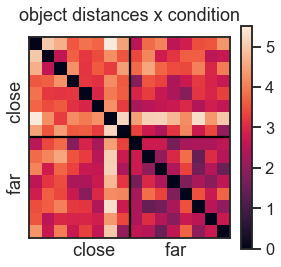

In [17]:
## produce visualization of matrix
from sklearn.metrics import *
sns.set_style('white')
D = pairwise_distances(fmat,metric='euclidean')
plt.matshow(D)
plt.plot((7.5, 7.5), (-0.5, 15.5), 'k-') # vertical refline
plt.plot((-0.5, 15.5), (7.5, 7.5), 'k-') # horizontal refline
plt.colorbar(fraction=0.05)
plt.xticks([])
plt.yticks([])
plt.xlabel('close          far')
plt.ylabel('far          close')
plt.title('object distances x condition')

###### Refresher on properties of variance
https://en.wikipedia.org/wiki/Variance

$ \operatorname{Var}(X) = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2 $

$ \operatorname{Var}(X) = \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n \frac{1}{2}(x_i - x_j)^2 = \frac{1}{n^2}\sum_i \sum_{j>i} (x_i-x_j)^2. $

In [18]:
## for each category, compare the within-condition variance 
## and the length of the centroid vector 
to_inspect = 'category'
dist_metric = 'euclidean'
categories = ['bird','car','chair','dog']

for i, this_category in enumerate(categories):
    c,f = subset_dataframe_by_condition(F2,
                                        to_inspect=to_inspect,
                                        this_category=this_category) ## get subset of features

    fmat = np.vstack((np.array(c),np.array(f))) ## stack
    D = pairwise_distances(fmat,metric=dist_metric) ## get distances
    dim = D.shape[0]
    half_dim = int(dim/2)
    triu_inds = np.triu_indices(half_dim,k=1)

    ## get pairwise distances between objects within context condition
    close_pairwise_dists = D[:half_dim,:half_dim][triu_inds]
    far_pairwise_dists = D[half_dim:dim,half_dim:dim][triu_inds]


    ## get euclidean distances of each object from origin 
    frob_c = np.apply_along_axis(np.linalg.norm,1,c)
    frob_f = np.apply_along_axis(np.linalg.norm,1,f)

    ## get std and mean distance from zero for each condition
    far_std = np.mean(far_pairwise_dists)
    far_mean = np.mean(frob_f)

    close_std = np.mean(close_pairwise_dists)
    close_mean = np.mean(frob_c)

    ## compute coefficient of variation, 
    ## measure of what percentage of the mean the dispersion is ...co
    ## if low, indicates higher mean relative to variance
    ## if high, indicates higher variance relative to mean
    ## https://en.wikipedia.org/wiki/Coefficient_of_variation
    far_cv = far_std/far_mean
    close_cv = close_std/close_mean
    print 'Category: {} | CV for close: {}, CV for far: {}.'.format(this_category, close_cv.round(3), far_cv.round(3))


Category: bird | CV for close: 0.795, CV for far: 0.588.
Category: car | CV for close: 0.702, CV for far: 0.653.
Category: chair | CV for close: 0.713, CV for far: 0.579.
Category: dog | CV for close: 0.899, CV for far: 0.804.


- Lower CV for far indicates tighter distribution, even accounting for distance from origin.
    That is, far sketches are more similar to each other than close sketches are to each other.

In [19]:
##Some sanity checks for how CV scales

c_mock = np.random.randint(40,80,(32,48))
f_mock = np.random.randint(0,50,(32,48))
c_double = c_mock*2

fmat = np.vstack((c_mock,f_mock)) ## stack
D = pairwise_distances(fmat,metric=dist_metric) ## get distances
dim = D.shape[0]
half_dim = int(dim/2)
triu_inds = np.triu_indices(half_dim,k=1)

D_mock = pairwise_distances(np.vstack((c_double,f_mock)),metric=dist_metric)



## get pairwise distances between objects within context condition
close_pairwise_dists = D[:half_dim,:half_dim][triu_inds]

far_pairwise_dists = D[half_dim:dim,half_dim:dim][triu_inds]

c_double_close_pairwise_dists= D_mock[:half_dim,:half_dim][triu_inds]
c_double_far_pairwise_dists= D_mock[half_dim:dim,half_dim:dim][triu_inds]

## get euclidean distances of each object from origin 
frob_c = np.apply_along_axis(np.linalg.norm,1,c_mock)
frob_f = np.apply_along_axis(np.linalg.norm,1,f_mock)
frob_c_double = np.apply_along_axis(np.linalg.norm,1,c_double)

## get std and mean distance from zero for each condition
far_std = np.mean(far_pairwise_dists)
far_mean = np.mean(frob_f)

close_std = np.mean(close_pairwise_dists)
close_mean = np.mean(frob_c)

c_double_close_std= np.mean(c_double_close_pairwise_dists)
c_double_close_mean = np.mean(c_double)

c_double_far_std = np.mean(c_double_far_pairwise_dists)
c_double_far_mean = np.mean(frob_f)
## compute coefficient of variation, 
## measure of what percentage of the mean the dispersion is ...co
## if low, indicates higher mean relative to variance
## if high, indicates higher variance relative to mean
## https://en.wikipedia.org/wiki/Coefficient_of_variation
far_cv = far_std/far_mean
close_cv = close_std/close_mean
double_c_close_cv = c_double_close_std/c_double_close_mean
double_c_far_cv = c_double_far_std/c_double_far_mean


print ' CV for close: {}, CV for far: {},\
 mock CV close:{}, mock CV far: {}'.format(far_cv.round(4), close_cv.round(4), double_c_close_cv.round(4), \
                                           double_c_far_cv.round(4))

print 'close-far CV ratio for no manipulation  : {}, close-far CV ratio for double c : {}'.format((far_cv/close_cv).round(4),\
                                                                                              (double_c_far_cv/double_c_close_cv).round(4))


 CV for close: 0.7192, CV for far: 0.2716, mock CV close:1.9167, mock CV far: 0.7192
close-far CV ratio for no manipulation  : 2.6484, close-far CV ratio for double c : 0.3752


There appears to be some amount of CV scaling that happens as vector lengths increase(?)

### characterize "context difference vector"

In [20]:
def flatten(x):
     return [item for sublist in x for item in sublist]
    
def get_ordered_objs_list_by_category(F):
    objs_list = []
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'
    categories = ['bird','car','chair','dog']
    for this_category in categories:
        category_inds = F['category'] == this_category
        objs_list.append(list(F[(category_inds) & (far_inds)].reset_index(drop=True).target.values))
    return flatten(objs_list)

ordered_objs = get_ordered_objs_list_by_category(F2)

In [21]:
## get difference between close and far
to_inspect = 'category'
categories = ['bird','car','chair','dog']
this_category = categories[0]
d = []
for i, this_category in enumerate(categories):
    c,f = subset_dataframe_by_condition(F2,
                                        to_inspect=to_inspect,
                                        this_category=this_category) ## get subset of features

    _d = c.sub(f)
    if len(d)==0:
        d = _d
    else:
        d = pd.concat((d,_d),axis=0)

<Figure size 576x576 with 0 Axes>

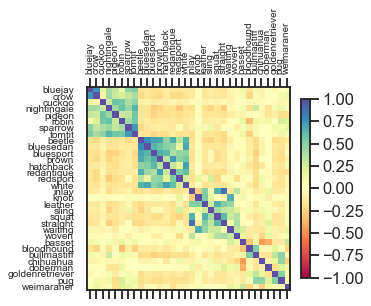

In [22]:
## visualize how well aligned the difference vectors are within a category
dist_metric = 'correlation'
D = 1 - pairwise_distances(d,metric=dist_metric)
fig = plt.figure(figsize=(8,8))
plt.matshow(D, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
plt.colorbar(fraction=0.04)
plt.xticks([])
plt.yticks([])
t = plt.xticks(range(len(ordered_objs)), ordered_objs, fontsize=10,rotation='vertical')
t = plt.yticks(range(len(ordered_objs)), ordered_objs, fontsize=10)

- Seems to be that for two of the categories, the difference vectors are all highly correlated with each other (bird, car), but this is less apparent for two of the other categories (chair, dog).

### measuring relative "spikiness" in close vs. far sketches?
Perhaps using Frobenius norm (root sum squares of each element in the vector),
 which is minimized for uniform vector, and larger for spikier vectors (with larger values concentrated in fewer dimensions)

In [23]:
## helpers
def entropy(probs):    
    return - 1 * sum(map(lambda x: x * np.log(x),probs))

def KL_div_uniform(probs):
    unif_p = 1/len(probs)
    return sum(map(lambda x: unif_p * np.log(unif_p/x),probs))

def softmax(X):
    '''
    input: X is a (1 x N) array
    output: 1 x N array
    '''
    return np.exp(X)/np.sum(np.exp(X))


def minmaxscale(X):

    return (X-np.min(X))/(np.max(X)-np.min(X))

In [24]:
## extract just the feature columns of the feature matrix, and break out by context 
to_inspect = 'all'
c,f = subset_dataframe_by_condition(F2,to_inspect=to_inspect)

## convert to numpy array
c = np.array(c)
f = np.array(f)

scale_mode='minmax'  ## minmax or softmax

if scale_mode == 'softmax':
    ## softmax
    soft_c = np.apply_along_axis(softmax,1,c)
    soft_f = np.apply_along_axis(softmax,1,f)
    ## get "spikiness" index on close and far average sketches for each object
    close_norm = np.apply_along_axis(np.linalg.norm,1,soft_c)
    far_norm = np.apply_along_axis(np.linalg.norm,1,soft_f)
    diff_norm = close_norm - far_norm  
elif scale_mode == 'minmax':
    ##minmax

    minmax_c = np.apply_along_axis(minmaxscale,1,c)
    minmax_f = np.apply_along_axis(minmaxscale,1,f)
    ## get "spikiness" index on close and far average sketches for each object
    close_norm = np.apply_along_axis(np.linalg.norm,1,minmax_c)
    far_norm = np.apply_along_axis(np.linalg.norm,1,minmax_f)
    diff_norm = close_norm - far_norm

Mean close spikiness = 2.3913  (higher values are spikier)
Mean far spikiness = 2.4794
Mean close-far difference on spikiness = -0.0881


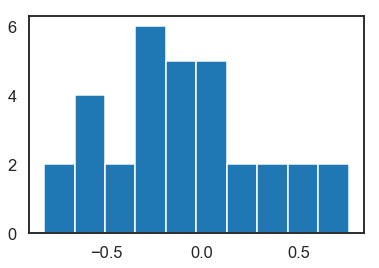

In [25]:
h = plt.hist(diff_norm)
print 'Mean close spikiness = {}  (higher values are spikier)'.format(np.mean(close_norm).round(4))
print 'Mean far spikiness = {}'.format(np.mean(far_norm).round(4))
print 'Mean close-far difference on spikiness = {}'.format(np.mean(diff_norm).round(4))

In [26]:
sp = sum(np.array(diff_norm)>0)
print 'Number of objects for which close was spikier than far: {}'.format(sp)

Number of objects for which close was spikier than far: 13


In [27]:
if scale_mode == 'softmax':
    mean_soft_c= np.mean(soft_c,0)
    mean_soft_f = np.mean(soft_f,0)
    l = plt.plot(soft_c[1,:].T,label='close')
    l = plt.plot(soft_f[1,:].T,label='far')
    plt.legend()
    plt.xlabel('feature dim')
    plt.ylabel('softmax feature weight')

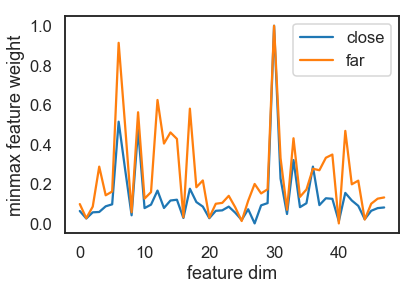

In [28]:
if scale_mode == 'minmax':
    l = plt.plot(minmax_c[0,:].T,label='close')
    l = plt.plot(minmax_f[0,:].T,label='far')
    plt.legend()
    plt.xlabel('feature dim')
    plt.ylabel('minmax feature weight')

In [29]:
## TODO: Looks like the pattern of peaks might be preserved between close and far, just taller peaks for close, 
## but rank ordering of peaks is preserved? If that is the case, then we predict that the Spearman correlation 
## coefficient will be high between close and far vectors for each object... 
import scipy.stats
run= False
if run==True:
    for i in range(32):
        plt.figure()
        s = plt.scatter(soft_c[i,:],soft_f[i,:])
        plt.title(stats.spearmanr(soft_c[i,:],soft_f[i,:]))


SpearmanrResult(correlation=0.8735345201910552, pvalue=5.504635674934761e-16)


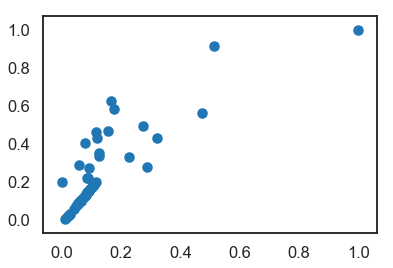

In [30]:
if scale_mode == 'minmax':
    s = plt.scatter(minmax_c[0,:],minmax_f[0,:])
    import scipy.stats
    print stats.spearmanr(minmax_c[0,:],minmax_f[0,:])

In [31]:
# zip(obj_list,diff_norm,np.arange(32))

### Is the rank ordering of spikes between close-far pairs of the same object significantly different than rank ordering of permuted pairs?

In [32]:
import scipy.stats as stats


In [49]:
def calculate_CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return  (m-h).round(3), (m+h).round(3)


<Figure size 576x576 with 0 Axes>

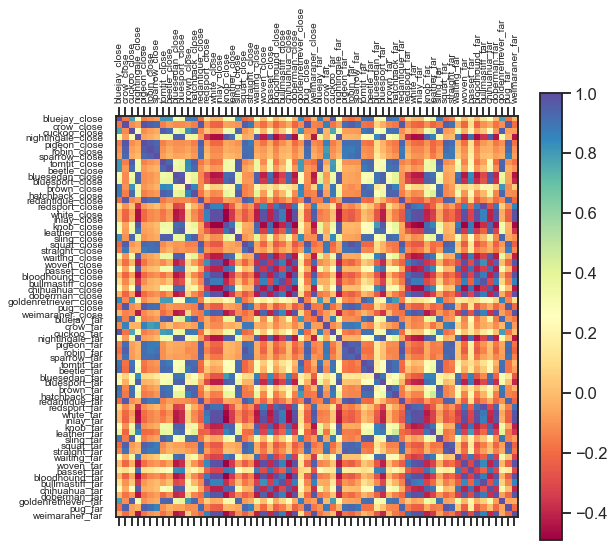

In [50]:
close_objs,far_objs = subset_dataframe_by_condition(F2, to_inspect= 'all' )
close_objs_sm = np.apply_along_axis(softmax,1,close_objs)
far_objs_sm = np.apply_along_axis(softmax,1,far_objs)
all_objs_sm= np.vstack((np.array(close_objs_sm),np.array(far_objs_sm)))
corr_matrix, p = stats.spearmanr(all_objs_sm.T)
plt.figure(figsize(8,8))
plt.matshow(corr_matrix, cmap=plt.cm.Spectral)
plt.colorbar(fraction=0.05)
plt.xticks([])
plt.yticks([])
close_far_labels =  [s +'_close' for s in ordered_objs]+[s +'_far' for s in ordered_objs]
t = plt.xticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10,rotation='vertical')
t = plt.yticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10)


Category: chair | The mean of corr coefficients for close-far pairs of the same object is 1.648,CI:(1.597, 1.699)     while the mean of the corr coefficients for permuted pairs is -0.014,CI:(-0.098, 0.069)


<Figure size 576x576 with 0 Axes>

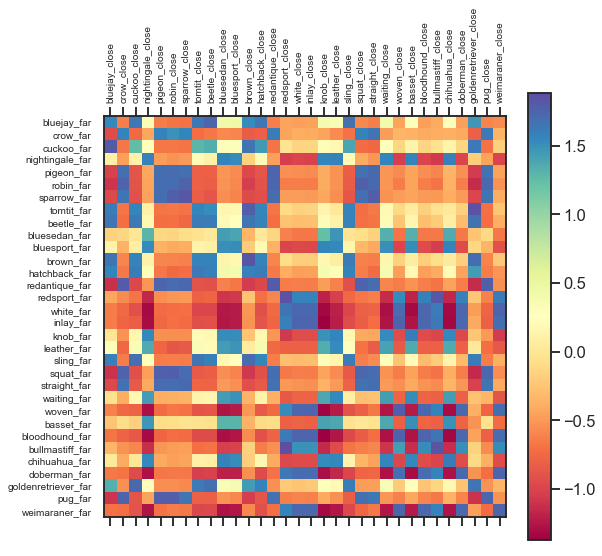

In [51]:
dim=corr_matrix.shape[0]
half_dim = int(corr_matrix.shape[0]/2)
cf_corr = corr_matrix[half_dim:dim,:half_dim]
cf_corr = stats.zscore(cf_corr)

plt.figure(figsize(8,8))
plt.matshow(cf_corr, cmap=plt.cm.Spectral)
plt.colorbar(fraction=0.05)
plt.xticks([])
plt.yticks([])

t = plt.xticks(range(len(ordered_objs)), [s +'_close' for s in ordered_objs], fontsize=10,rotation='vertical')
t = plt.yticks(range(len(ordered_objs)), [s +'_far' for s in ordered_objs], fontsize=10)
cf_matched_mean = np.mean(np.diag(cf_corr))
triu_inds = np.triu_indices(half_dim,1)
cf_off_diag = cf_corr[triu_inds]
cf_permuted_mean = cf_off_diag.mean()
print 'Category: {} | The mean of corr coefficients for close-far pairs of the same object is {},CI:{}\
     while the mean of the corr coefficients for permuted pairs is {},CI:{}'.format(this_category, cf_matched_mean.round(3),\
                                                                                    calculate_CI(np.diag(cf_corr)),\
                                                                               cf_permuted_mean.round(3), calculate_CI(cf_off_diag))

    


Category: bird | The mean of corr coefficients for close-far pairs of the same object is 0.339,CI:(-0.216, 0.895)     while the mean of the corr coefficients for permuted pairs is 0.046,CI:(-0.366, 0.457)
Category: car | The mean of corr coefficients for close-far pairs of the same object is 0.3,CI:(-0.687, 1.287)     while the mean of the corr coefficients for permuted pairs is -0.194,CI:(-0.659, 0.272)
Category: chair | The mean of corr coefficients for close-far pairs of the same object is 0.936,CI:(0.53, 1.342)     while the mean of the corr coefficients for permuted pairs is -0.129,CI:(-0.504, 0.246)
Category: dog | The mean of corr coefficients for close-far pairs of the same object is 0.04,CI:(-0.93, 1.011)     while the mean of the corr coefficients for permuted pairs is -0.146,CI:(-0.61, 0.317)


<Figure size 576x576 with 0 Axes>

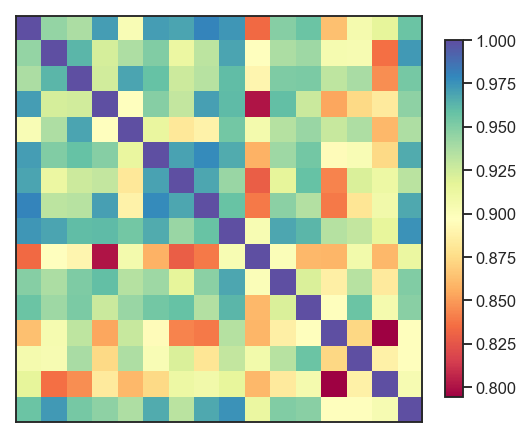

<Figure size 576x576 with 0 Axes>

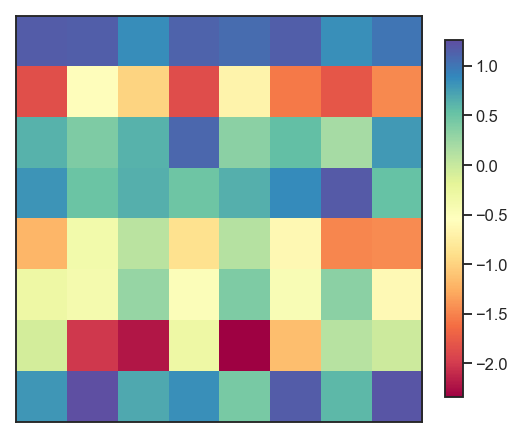

<Figure size 576x576 with 0 Axes>

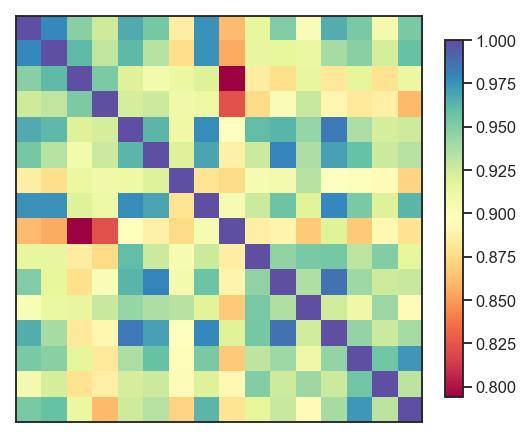

<Figure size 576x576 with 0 Axes>

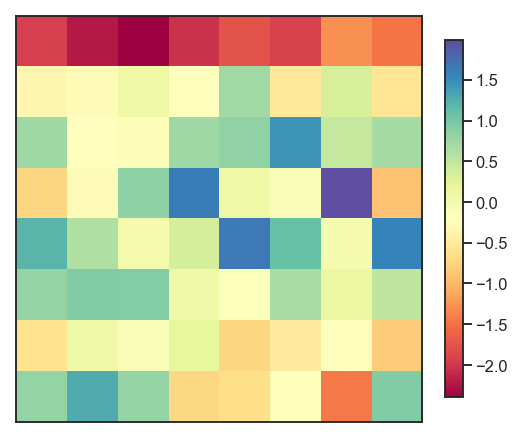

<Figure size 576x576 with 0 Axes>

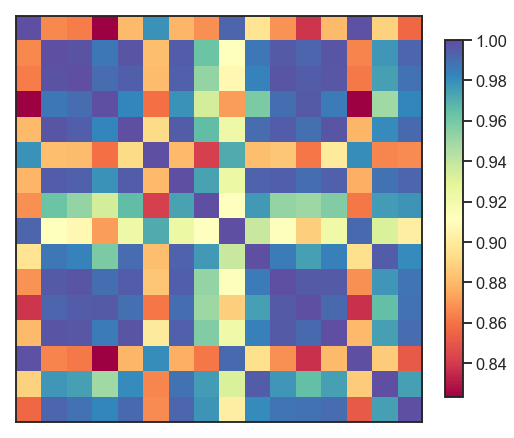

<Figure size 576x576 with 0 Axes>

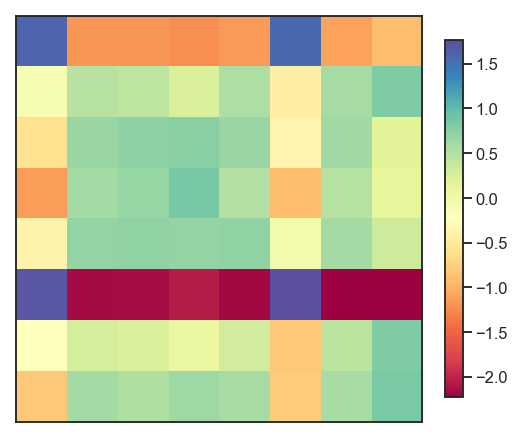

<Figure size 576x576 with 0 Axes>

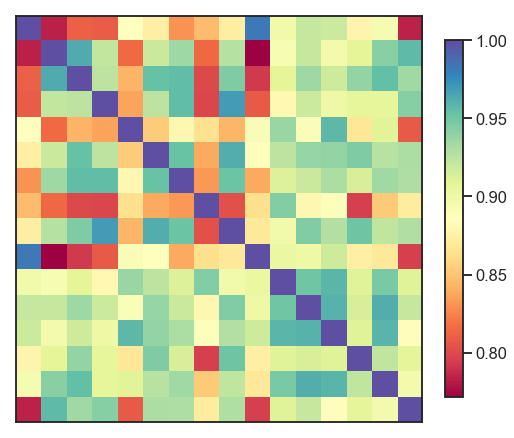

<Figure size 576x576 with 0 Axes>

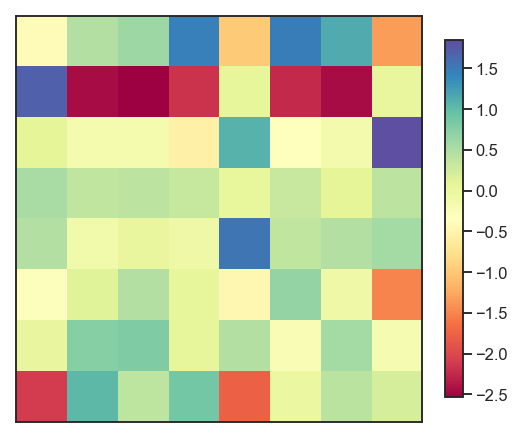

In [52]:
for i, this_category in enumerate(categories):
    close_objs,far_objs = subset_dataframe_by_condition(F2, to_inspect= 'category',this_category=this_category )
    close_objs_sm = np.apply_along_axis(softmax,1,close_objs)
    far_objs_sm = np.apply_along_axis(softmax,1,far_objs)
    all_objs_sm= np.vstack((np.array(close_objs_sm),np.array(far_objs_sm)))
    corr_matrix, p = stats.spearmanr(all_objs_sm.T)
    plt.figure(figsize(8,8))
    plt.matshow(corr_matrix, cmap=plt.cm.Spectral)
    plt.colorbar(fraction=0.04)
    plt.xticks([])
    plt.yticks([])
    close_far_labels =  [s +'_close' for s in ordered_objs]+[s +'_far' for s in ordered_objs]
    dim=corr_matrix.shape[0]
    half_dim = int(corr_matrix.shape[0]/2)
    cf_corr = corr_matrix[half_dim:dim,:half_dim]
    cf_corr = stats.zscore(cf_corr)
    plt.figure(figsize(8,8))
    plt.matshow(cf_corr, cmap=plt.cm.Spectral)
    plt.colorbar(fraction=0.04)
    plt.xticks([])
    plt.yticks([])

    #t = plt.xticks(range(len(ordered_objs)), [s +'_close' for s in ordered_objs], fontsize=10,rotation='vertical')
    #t = plt.yticks(range(len(ordered_objs)), [s +'_far' for s in ordered_objs], fontsize=10)
    cf_matched_mean = np.mean(np.diag(cf_corr))
    triu_inds = np.triu_indices(half_dim,1)
    cf_off_diag = cf_corr[triu_inds]
    cf_permuted_mean = cf_off_diag.mean()
    print 'Category: {} | The mean of corr coefficients for close-far pairs of the same object is {},CI:{}\
     while the mean of the corr coefficients for permuted pairs is {},CI:{}'.format(this_category, cf_matched_mean.round(3),\
                                                                                    calculate_CI(np.diag(cf_corr)),\
                                                                               cf_permuted_mean.round(3), calculate_CI(cf_off_diag))

    


### relationship between numstrokes and arclength features in unaggregated feature matrix (at sketch level)
I.e., Check how redundant the num strokes vector is with the arclength vector across sketches (how correlated are the 23 vectors across sketches within an object?) 

In [36]:
from scipy.spatial import distance
if dataset=='normalized':
    assert len(np.unique(F[arclength_cols].sum(axis=1).round(10)))==1
    assert len(np.unique(F[numstrokes_cols].sum(axis=1).round(10)))==1

In [37]:
## inspect particular category
this_category = 'chair'
category_inds = F['category']==this_category

In [38]:
## extract matrix form of just the arclength and numstrokes columns
to_inspect = 'all'
if to_inspect == 'category':
    arcF = np.array(F[category_inds][arclength_cols])
    numF = np.array(F[category_inds][numstrokes_cols])
elif to_inspect == 'all':
    arcF = np.array(F[arclength_cols])
    numF = np.array(F[numstrokes_cols])    

#### Get a sense for how correspondent the numstrokes and arclength features are (how redundant are they?)

In [39]:
## get distances between sketches using either numstrokes (numF) or arclength (arcF)
feat_type = numF
D = pairwise_distances(feat_type,metric='euclidean')
dists_within_metric = D[np.triu_indices(D.shape[0], k=1)]
print 'Mean euclidean distance between sketches using a single metric (numstrokes or arclength): {}'.format(np.mean(dists_within_metric).round(5))

## get correspondence between numstrokes and arclength feature
dists_btw_metrics = [distance.euclidean(arcV,numV) for(arcV, numV) in zip(arcF,numF)]
print 'Mean euclidean distance within sketches between arclength and numstrokes feature vectors: {}'.format(np.mean(dists_btw_metrics).round(5))

## get distance between randomly sampled numstroke and arclength vector from different sketches
nIter = 1000
num_sketches = np.shape(arcF)[0]
dists_btw_metrics_permuted = []
for this_iter in np.arange(nIter):
    rand_inds = np.random.RandomState(this_iter).choice(num_sketches,2)
    arcV = arcF[rand_inds[0],:]
    numV = numF[rand_inds[1],:]
    dists_btw_metrics_permuted.append(distance.euclidean(arcV,numV))
print "Mean euclidean distance between randomly sampled sketches' arclength and numstrokes feature vectors: {}".format(np.mean(dists_btw_metrics_permuted).round(5)) 

Mean euclidean distance between sketches using a single metric (numstrokes or arclength): 6.14645
Mean euclidean distance within sketches between arclength and numstrokes feature vectors: 2.7935
Mean euclidean distance between randomly sampled sketches' arclength and numstrokes feature vectors: 5.98081


#### Hmm, maybe a better way to do this. How about learning linear mapping from numstrokes to arclength and computing variance explained?

In [40]:
## Assume linear function to map from X to y
## y = Xb
X = arcF 
y = numF

## solve for b directly using pseudo inverse
b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
yhat = X.dot(b)

## get proportion of variance explained
## https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained
## Fraction of variance unexplained, FVU = SS_err / SS_tot
SS_err = np.sum([distance.euclidean(_yhat,_y)**2 for (_yhat, _y) in zip(yhat,y)])
SS_tot = np.sum([distance.euclidean(_y,y.mean(0))**2 for _y in y])
FVU = SS_err / SS_tot
print 'Fraction of variance unexplained after learning linear mapping to arclength to get numstrokes is: {}.'.format(FVU)

Fraction of variance unexplained after learning linear mapping to arclength to get numstrokes is: 0.39542538094.
